# Detecting Activity Types from Accelerometer Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.signal import welch

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score

import itertools
import time

from sigmod.load import load_signal_data
from sigmod.plots import *
from sigmod.signal_processing import *

In [2]:
train_signals, train_labels, test_signals, test_labels = load_signal_data()

### Background and Data Source

The data is captured by accelerometers in Samsung Galaxy phones, which were attached to subjects' waists while they participated in 6 different activities:

* 1: walking
* 2: walking up stairs
* 3: walking down stairs
* 4: sitting
* 5: standing
* 6: laying

The following 6 plots show how the accelerometer data differ between each activity

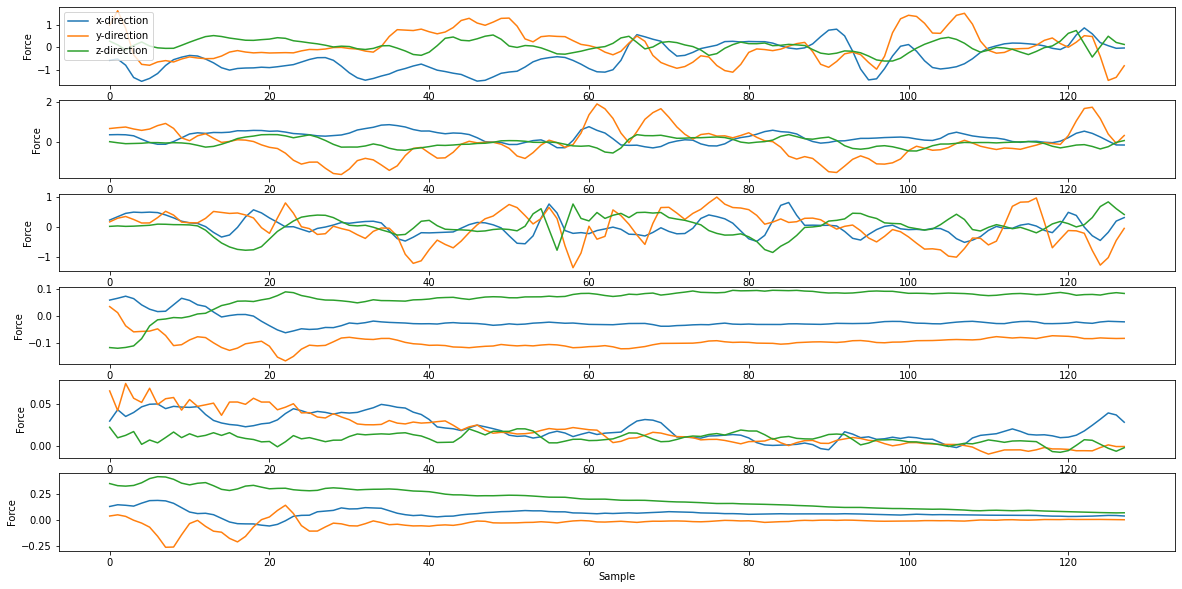

In [3]:
show_true_signals(train_signals, train_labels)

The data consists of 10,299 samples, each of which is composed of 9 different signals. The signals are separated into "acceleration", "gyroscopic motion", and "total acceleration", each in the x, y, and z directions (3 types of motion in 3 directions = 9 signals per sample). We can imagine a single sample of 9 signals as represented in the 3D plot below. 

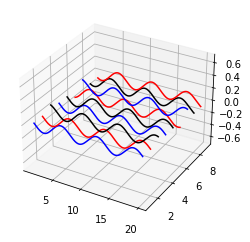

In [4]:
show_single_sample()

After loading the data with the `load_signal_data()` function, it is stored in a 3-D matrix of size 10,299 x 128 x 9. A couple signal processing techniques will allow us to flatten this and represent it as a 2-D matrix of size 10,299 x m (where m is the number of features). Then we can use this 2-D matrix to train a Random Forest classifier.  

Additionally, the original dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) is already separated into a train and test set, so we'll first concatenate these sample matrices and target vectors such that we can run k-fold cross validation later on.


In [5]:
signals = np.concatenate([train_signals, test_signals])
labels = np.concatenate([train_labels, test_labels])
signals.shape, train_signals.shape

((10299, 128, 9), (7352, 128, 9))

Now, we'll walk through an explanation of how we extract the features from the 9 signals that compose each sample. This is done with the *Fourier Transform* and the *Autocorrelation*. 

### Signal Processing Technique 1: The Fourier Transform

The Fourier transform helps us represent signals in the frequency/amplitude domain rather than the time/amplitude domain. It allows us to extract the underlying frequencies in a signal that may be composed of more than just one. 

Below, we use a set of sample sine waves, each of which is given by the equation:

>$$ y = Asin(2\pi\omega t)$$
>
> where $A$ represents the amplitude
>
>and $\omega$ represents the angular frequency in radians per second

The Fourier Transform is given by the equation:


$$F(\omega)= \int_{-\infty}^{\infty}{f(t)e^{-j\omega t}dt}$$

We set the signal length to 10 seconds and the number of samples to 1000, which means that we are collecting 100 samples per second (i.e. our sample frequency is 100 Hz).

Each individual sine wave is modeled by the curves in blue through red with the following frequencies and amplitudes:

| Color       | Frequency $\omega$   | Amplitude $A$ |
| ----------- | ----------- |---------- |
| Blue        | 6.5         |      4     |
| Orange      | 5           |      6     |
| Purple      | 3           |      8     |
| Green       | 1.5         |     10      |
| Red         | 1           |     14      |
 

Then they are summed up to create the composite wave in black in the plots below. The Fourier Transform can help us extract the underlying frequencies in this black sinusoid, which we know should be 6.5, 5, 3, 1.5, 1 radians per second respectively. The plot of frequencies vs. amplitudes should also show that the amplitude for the 1 rad/sec frequency is most prominent (i.e. largest amplitude) followed by the 1.5 rad/sec frequency, etc.


In [6]:
t_n = 10     #timespan
N = 1000     #number of points in each signal
T = t_n / N  #time interval between points
f_s = 1/T    #sampling frequency

x = np.linspace(0, t_n, N)

amplitudes  =  [4, 6, 8, 10, 14]
frequencies =  [6.5, 5, 3, 1.5, 1]


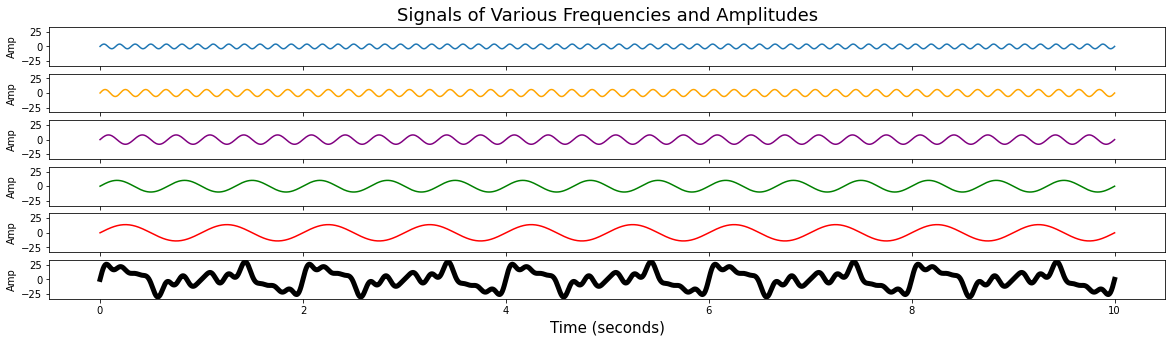

In [7]:
composite_y_value = plot_premade_signals(x, amplitudes,frequencies)

Here, we implement the `signal_processing.get_fourier_peaks` function that will first extract the underlying frequencies from our black composite sine wave. 

We'll check to see that it works properly using the sample composite wave we built above, then we'll use it to extract features for our machine learning model down the line.

Frequencies: [1.  1.5 3.  5.  6.5], 
Corresponding Amplitudes: [14.02  9.97  7.98  5.96  3.93]


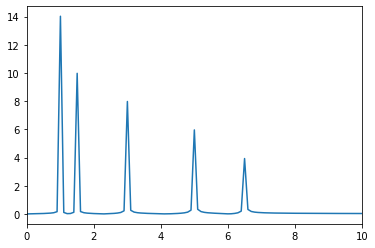

In [8]:
get_fourier_peaks(composite_y_value, samplingFrequency=100,npeaks =5, demo = True)
plt.xlim(0,10)
plt.show()

Sure enough, the locations of the peaks in the plot above reflect the frequencies and amplitudes we selected. We designed a composite curve so that we could build a fourier transform function and make sure it will work when we apply it to our real signals. 

### Signal Processing Technique 2: Autocorrelation

We carry out the same demonstration of how autocorrelation works in the `autocorr.ipynb` notebook. The `signal_processing.get_autocorr_peaks` explains how each signal relates to a time-shifted version of itself. 

Time Delays: [0.64 0.77 1.   1.22 1.35], 
Corresponding Amplitudes: [15219.86 33485.7  80979.03 51641.02 27986.61]


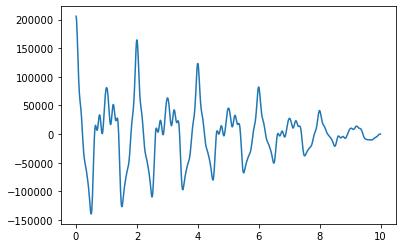

In [9]:
get_autocorr_peaks(composite_y_value, T = T, N = N, demo = True, npeaks = 5)

### Extracting a 2D Array

Each signal processing function will extract `npeaks` $\times \space$2  features. For example, if we pass in `npeaks = 5` to the `get_fourier_peaks` function, it will output 10 datapoints:
* 5 data points reflecting the underlying frequencies of the signal
* 5 data points reflecting the amplitudes of these frequencies

Each row vector therefore becomes 10 data points per function per signal. 10 * 2 * 9 = 180 features. This is extracted by our `get_features` function. Our final 2D matrix stacks these vectors vertically and becomes 10,299 x 180 in size.

In [10]:
def get_features(signals, peaks = 5):
    '''Input: 9 x 128 array from one sample of our 3D matrix
       Output: Row vector of size 9*2*2*npeaks for use in our 2D array'''
    
    signals = signals.T
    f_peaks = []
    for i in range(signals.shape[0]):
        f_peaks.append(get_fourier_peaks(signals[i], npeaks = peaks))
        f_peaks.append(get_autocorr_peaks(signals[i], npeaks = peaks))
    
    return(np.array(f_peaks).reshape(-1))


### Building a Model

In [11]:
X = []
y = []

for i in range(signals.shape[0]):
    X.append(get_features(signals[i]))
    y.append(labels[i])

X = np.array(X)
y = np.array(y)

In [12]:
X.shape, y.shape

((10299, 180), (10299,))

In [25]:
#test a single random forest model with 100 trees

start = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, stratify = y)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_std, y_train)
print(f'Random State: {i}, Score: {clf.score(X_test_std, y_test)}')
    
end = time.time()

print(f'Train and Test time: {end-start} seconds')

Random State: 0, Score: 0.8883495145631068
Train and Test time: 4.218571901321411 seconds


We've gotten a baseline score of 0.888 with 100 trees. Let's see if we can find parameters that will optimize this score.

### Grid Search Cross Validation By Hand

Just to practice, below we find the optimal parameters for a Random Forest Classifier without using scikit's built-in cross validation library. We store the parameters in a dataframe as well as the corresponding score and the time (in seconds) to train and test each iteration.

Since we have about 6 different labels, we can rely on the accuracy to give us an understanding of how our model performs (where maybe we should rely on an $F_\beta$ score if we had a binary classification situation.

In [32]:
#split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, stratify = y, random_state = 1)

In [33]:
#create a dictionary of parameters

params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 300]}

In [34]:
#create a list of tuples, where each tuple is a different combination of model parameters

param_lists = []
for i in params.keys():
    param_lists.append(params[i])
    
param_combos = list(itertools.product(*param_lists))

In [79]:
#check to see that it worked as expected by printing random samples
for i in range(5):
    print(param_combos[i*30])

(True, 10, 'auto', 1, 2, 200)
(True, 10, 'sqrt', 4, 2, 200)
(True, 20, 'sqrt', 2, 2, 200)
(True, 30, 'sqrt', 1, 2, 200)
(True, None, 'auto', 4, 2, 200)


In [35]:
#start a timer for the entire grid search cross validation
start = time.time()

#initiate lists to store the iterations' respective parameter values
bootstraps = []
depths = []
features= []
leafs = []
splits = []
estimators = []
scores = []
times = []

metric_columns = [bootstraps,
                  depths,
                  features,
                  leafs,
                  splits,
                  estimators]

#for each iteration:
#...build a model, train on the train set, output the score, output the time to train and test that iteration
for i in param_combos:
    combo_start = time.time()
    
    for j in range(len(i)):
        metric_columns[j].append(i[j])
        
        
    clf = RandomForestClassifier(
        bootstrap = i[0],
        max_depth = i[1],
        max_features = i[2],
        min_samples_leaf = i[3],
        min_samples_split = i[4],
        n_estimators = i[5])
        
    
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    combo_end = time.time()
    times.append(combo_end-combo_start)
    
    
end = time.time()

print(f'Time to train and test {len(param_combos)} models: {end-start} seconds')

Time to train and test 288 models: 3487.990233898163 seconds


In [36]:
#create a dataframe of the parameters and corresponding scores and times
metrics = pd.DataFrame()

keys = list(params.keys())

for i in range(len(keys)):
    metrics[keys[i]] = metric_columns[i]
    
metrics['scores'] = scores
metrics['times'] = times

In [81]:
#display a sample of the metrics
metrics.sample(10)

,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,scores,times
210,False,20.0,sqrt,4,2,200,0.898544,12.058600
224,False,30.0,auto,2,5,200,0.908738,12.845863
192,False,20.0,auto,4,2,200,0.900971,12.490003
141,True,NaN,sqrt,4,5,300,0.894175,11.110373
11,True,10.0,auto,2,10,300,0.882039,9.172493
27,True,10.0,sqrt,2,5,300,0.881068,9.165540
1,True,10.0,auto,1,2,300,0.883495,9.265810
170,False,10.0,sqrt,2,5,200,0.887379,9.564931
96,True,30.0,sqrt,2,2,200,0.898058,8.209348
209,False,20.0,sqrt,2,10,300,0.905825,18.900251


In [65]:
#print the best parameters (based on the highest accuracy)
print('BEST PARAMETERS:\n--------')
vals = metrics[metrics.scores == metrics.scores.max()].values[0]

for i in range(len(metrics.columns)-2):
    print(f'{metrics.columns[i]} : {vals[i]}')


BEST PARAMETERS:
--------
bootstrap : False
max_depth : 30.0
max_features : auto
min_samples_leaf : 1
min_samples_split : 2
n_estimators : 200


### K-Fold Cross Validation Using Scikit

Now we can use 10-fold cross validation to evaluate the optimal parameters on various splits of our dataset.

Below, we show the score corresponding to each fold as well as the average score for all 10 folds.

In [68]:
kf = KFold(n_splits =10)

In [75]:
scores2 = []
i = 1
for train_idx, test_idx in kf.split(x):
    X_train2, X_test2 = X[train_idx], X[test_idx]
    y_train2, y_test2 = y[train_idx], y[test_idx]
    clf2 = RandomForestClassifier(
        bootstrap = False,
        max_depth = 30,
        max_features = 'auto',
        min_samples_leaf = 1,
        min_samples_split = 2,
        n_estimators = 200)
    
    clf2.fit(X_train, y_train)
    s = clf2.score(X_test, y_test)
    scores2.append(s)
    print(f'Fold Number: {i} --> Score: {s}')
    i+=1
    
print(f'Average Score: {np.array(scores2).mean()}')

Fold Number: 1 --> Score: 0.9092233009708738
Fold Number: 2 --> Score: 0.9077669902912622
Fold Number: 3 --> Score: 0.9053398058252428
Fold Number: 4 --> Score: 0.9101941747572816
Fold Number: 5 --> Score: 0.9063106796116505
Fold Number: 6 --> Score: 0.9097087378640777
Fold Number: 7 --> Score: 0.9097087378640777
Fold Number: 8 --> Score: 0.9063106796116505
Fold Number: 9 --> Score: 0.9053398058252428
Fold Number: 10 --> Score: 0.9063106796116505
Average Score: 0.9076213592233009
